## Defining the data mining goal
The goal of this project is to predict the level of obesity of a patient based on various data on the patient, instead of using the BMI which uses weight and height.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn import tree
from scipy import stats

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

from IPython.display import display, Latex

In [2]:
df = pd.read_csv('obesity_training_set_1.csv')
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


## Describing the attributes of the dataset
The following table describes the data in the dataset (BEFORE generating data synthetically).\
Based on the data article 'https://www.sciencedirect.com/science/article/pii/S2352340919306985?via%3Dihub#bib1', there are no null or missing values in the dataset.

| Attribute | Description | Type | Range or Values | Mean, Standard deviation |
|:---:|:---:|:---:|:---:|:---:|
| Gender | -- | categoric | male, female | -- |
| Age | -- | numeric | 14-61 | 24.3, 6.4 |
| Height | -- | numeric (meters) | 1.45-1.98 | 1.7, 0.1 |
| Weight | -- | numeric (kilograms) | 39-173 | 86.6, 26.2 |
| FHO | Whether or not a family member suffered or suffers from overweight | categoric | Yes, No | -- |
| FAVC | Frequent consumption of high caloric food | categoric | Yes, No | -- |
| FCVC | Frequency of consumption of vegetables | categoric | Never, Sometimes, Always | -- |
| NCP | Number of main meals | categoric | Between 1 and 2, Three, More than three | -- |
| CAEC | Consumption of food between meals | categoric | No, Sometimes, Frequently, Always | -- |
| SMOKE | Whether or not the person smokes | categoric | Yes, No | -- |
| CH2O | Consumption of water daily  | categoric | Less than a liter, Between 1 and 2 L, More than 2 L | -- |
| SCC | Calories consumption monitoring | categoric | Yes, No | -- |
| FAF | Physical activity frequency | categoric | I do not have, 1 or 2 days, 2 or 4 days, 4 or 5 days | -- |
| TUE | Time using technology devices | categoric | 0–2 hours, 3-5 hours, More than 5 hours | -- |
| CALC | Consumption of alcohol | categoric | I do not drink, Sometimes, Frequently, Always | -- |
| MTRANS | Transportation used | categoric | Automobile, Motorbike, Bike, Public Transportation, Walking | -- |
| NObeyesdad | Obesity Level | categoric | Insufficient Weight, Normal Weight, Overweight Level I, Overweight Level II, Obesity Type I, Obesity Type II and Obesity Type III | -- |

In [3]:
# to find the range, mean, and standard deviation
df[['Age', 'Height', 'Weight']].describe()

,Age,Height,Weight
count,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058
std,6.345968,0.093305,26.191172
min,14.000000,1.450000,39.000000
25%,19.947192,1.630000,65.473343
50%,22.777890,1.700499,83.000000
75%,26.000000,1.768464,107.430682
max,61.000000,1.980000,173.000000


Note: after the synthetic data was generated, new values (that were not included in the original data) were added to some of the discrete valued attributes (FCVC, NCP, CH2O, FAF, TUE).\
For example:

Rename the 'family_history_with_overweight' column to 'FHO' so the namings are consistent and compact.

In [4]:
df.rename(columns = {'family_history_with_overweight':'FHO'}, inplace = True)

df.sample(5, random_state=32)

,Gender,Age,Height,Weight,FHO,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
1416,Male,23.479181,1.680171,91.068054,yes,yes,1.220024,3.000000,Sometimes,no,1.046254,no,0.520989,0.61599,no,Automobile,Obesity_Type_I
199,Female,23.000000,1.660000,60.000000,yes,yes,2.000000,1.000000,Sometimes,no,1.000000,no,1.000000,1.00000,Sometimes,Public_Transportation,Normal_Weight
1324,Female,22.480889,1.605662,82.470375,yes,yes,1.557287,1.000000,Sometimes,no,2.371015,no,0.288032,2.00000,Sometimes,Public_Transportation,Obesity_Type_I
682,Female,19.007177,1.690727,49.895716,no,yes,1.212908,3.207071,Sometimes,no,1.029703,no,2.000000,1.00000,Sometimes,Public_Transportation,Insufficient_Weight
332,Male,27.000000,1.850000,75.000000,yes,yes,2.000000,1.000000,Sometimes,no,2.000000,no,1.000000,0.00000,no,Walking,Normal_Weight


In [5]:
# double checking there are no empty or null cells 
df.isnull().sum()

Gender        0
Age           0
Height        0
Weight        0
FHO           0
FAVC          0
FCVC          0
NCP           0
CAEC          0
SMOKE         0
CH2O          0
SCC           0
FAF           0
TUE           0
CALC          0
MTRANS        0
NObeyesdad    0
dtype: int64

## The KDD (Knowledge Discovery in Databases) proccess

*1. Setting a goal*\
\
The goal of this project is to predict the level of obesity of a patient based on various data on the patient, instead of using the BMI which uses weight and height.
\
\
*2. Data selection, integration, and storage*\
\
This step of the process was already partly done and describd in the article (linked in question 1.b). The dataset was saved from the following website:\
'https://www.kaggle.com/code/mpwolke/obesity-levels-life-style/data' as a CVS file.\
\
*3. Data cleaning and preprocessing*\
\
As mentioned above, there are no null or missing values in the dataset.\
I will remove outliers and check for duplicate data. In addition, I will change the values 'no' to 'Never' in the attibutes CALC and CAEC in order to make the data more understandable.\
Since the Weight and Height attributtes are used to calculate the BMI which is used to determinite the target attribute Obesity_Level, I will remove them.\
\
*4. Data transformation*\
\
First, I will transform the values of the relevant attributes back to integers.\
In addition, since data mining algorithms work with numerical values and not with caterorical values, I will encode the categorical attributes.\
No discretization was needed in the project because the algorithms in scikit-learn are able to handle continuous numerical data.\
\
*5. Data mining*\
\
In order to do the data mining I used Python and the mainly the pandas and scikit-learn libraries. As for this project, I manually tested various parameters to see which give me the best results.\
\
*6. Evaluation and interpretation of the results*\
\
For this step I used Python and the confusion matrix, again from the scikit-learn library.\
\
*7. Consolidating discovered knowledge*\
\
This step involves visualization of knowledge such as generating tables, reports, graphs or rules for decision making.

## Possible data mining methods

**- Linear regression**\
This method creates a model that assumes a linear relationship between the target attribute and the rest of the attributes. More specifically, a formula is used to predict the value of the target attribute.\
\
*Advantages include:*
- performs well if the linear relationship indeed exists.
- easy to implement
- can extrapolate beyond the data set (for example predict into the future)


*Disadvantages include:*

- assumes the linear relationship stated earlier
- sensitive to outliers
- prone to noise and overfitting

**- Polynomial regression**\
Similarly to the linear regression model, a formula is used to predict the value of the target attribute. In this method however, a linear relationship is not assumed, and a polynomial relationship is.\
\
*Advantages include:*
- can be used to fit non-linear data
- easy to implement
- can extrapolate beyond the data set (for example predict into the future)

*Disadvantages include:*
- sensitive to outliers
- prone to noise and overfitting

**- Decision tree using the CART algorithm**\
This method builds a binary decision tree based on Gini's impurity index as a splitting criterion.\
*Advantages include:*
- easy to understand, interpret, and visualize
- works with both continuous and discrete values
- works with numerical, categorical, or boolean values

*Disadvantages include:*
- relatively high time complexity to train the model
- inadequate for predictiong continuous values
- sensitive to new data (new data will likely change the model)

**- K nearest neighbors**\
This method finds the k most similar items to the item given (certain data) and returns a prediction based on that. The degree of similarity is determined by a certain distance (often the Eucledian distance)
*Advantages include:*
- very easy to implement, including for multi-class problems
- no training period - uses only real time calculations
- new data can be added seamlessly due to the lack of training

*Disadvantages include:*
- high time complexity with large datasets (calculates the distance to each point in the dataset)
- high time complexity with high dimentions (more time is required to calculate the distance)
- sensitive to noisy data, missing values, and outliers

## Data preparation

### Taking care of outliers
In the numerical attributes (age, height, weight) I remove entries where the z-score of that attribute is greater than 3 or less than -3.

In [6]:
# numeric attributes df
df_numerics = df[['Age', 'Height', 'Weight']]
# absolute values of z scores
abs_z_scores = np.abs(stats.zscore(df_numerics))
abs_z_scores
filtered_entries = (abs_z_scores < 3).all(axis=1)
num_outliers = filtered_entries[filtered_entries == False].count()
print('The number of outliers is:', num_outliers, 'out of', df.shape[0], 'entries.\n')

The number of outliers is: 25 out of 2111 entries.



Since the percentage of outliers is very low and the dataset is fairy large, I discard the outlier entries.

In [7]:
df = df[filtered_entries]
print('Now there are', df.shape[0], 'entries.')

Now there are 2086 entries.


### Removing duplicate entries

In [8]:
display(df.shape)
df.duplicated(subset=None, keep='first')
display(df.shape)

(2086, 17)

(2086, 17)

Therefore are no duplicate entries.

### Changing the 'no' values to 'Never' in the 'CALC' and 'CAEC' columns

In [9]:
df.loc[df['CALC'] == 'no', 'CALC'] = 'Never'
df.loc[df['CAEC'] == 'no', 'CAEC'] = 'Never'
df[['CALC', 'CAEC']].loc[(df['CALC'] == 'Never') & (df['CAEC'] == 'Never')].sample(3)

,CALC,CAEC
239,Never,Never
234,Never,Never
76,Never,Never


### Removing the attributes Height and Weight

Drop Height and Weight because they are used to calculate the Obesity_Level which is the target attribute.

In [10]:
df = df.drop(['Height', 'Weight'], axis=1)

### Rounding numbers to match the values entered in the survey

In the attributes FCVC, NCP, CH2O, FAF, TUE there were only a few options to choose from, and after synthetically generating data the attribute became "continous". Since this doesn't match the original questions of the survey, I round the values to the nearest integer.

In [11]:
df[['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']] = df[['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']].round()

If the above table is analyzed closely, one can see that the NCP (number of meals) attibute should only have 3 options (Between 1-2, Three, More than three), so values 1-3, not 1-4.\
Therefore I change all the values greater than 3 to 3.

In [12]:
df.loc[df['NCP'] > 3, 'NCP'] = 3
print(df[['NCP']].min())
print(df[['NCP']].max())
# Now the range is 1-3

NCP    1.0
dtype: float64
NCP    3.0
dtype: float64


Change the values to integers for a cleaner look (1 instead of 1.0)

In [13]:
for col in ['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']:
    df[[col]] = df[[col]].astype(int)
df[['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']].head()

,FCVC,NCP,CH2O,FAF,TUE
0,2,3,2,0,1
1,3,3,3,3,0
2,2,3,2,2,1
3,3,3,2,2,0
4,2,1,2,0,0


### Visualization of the data

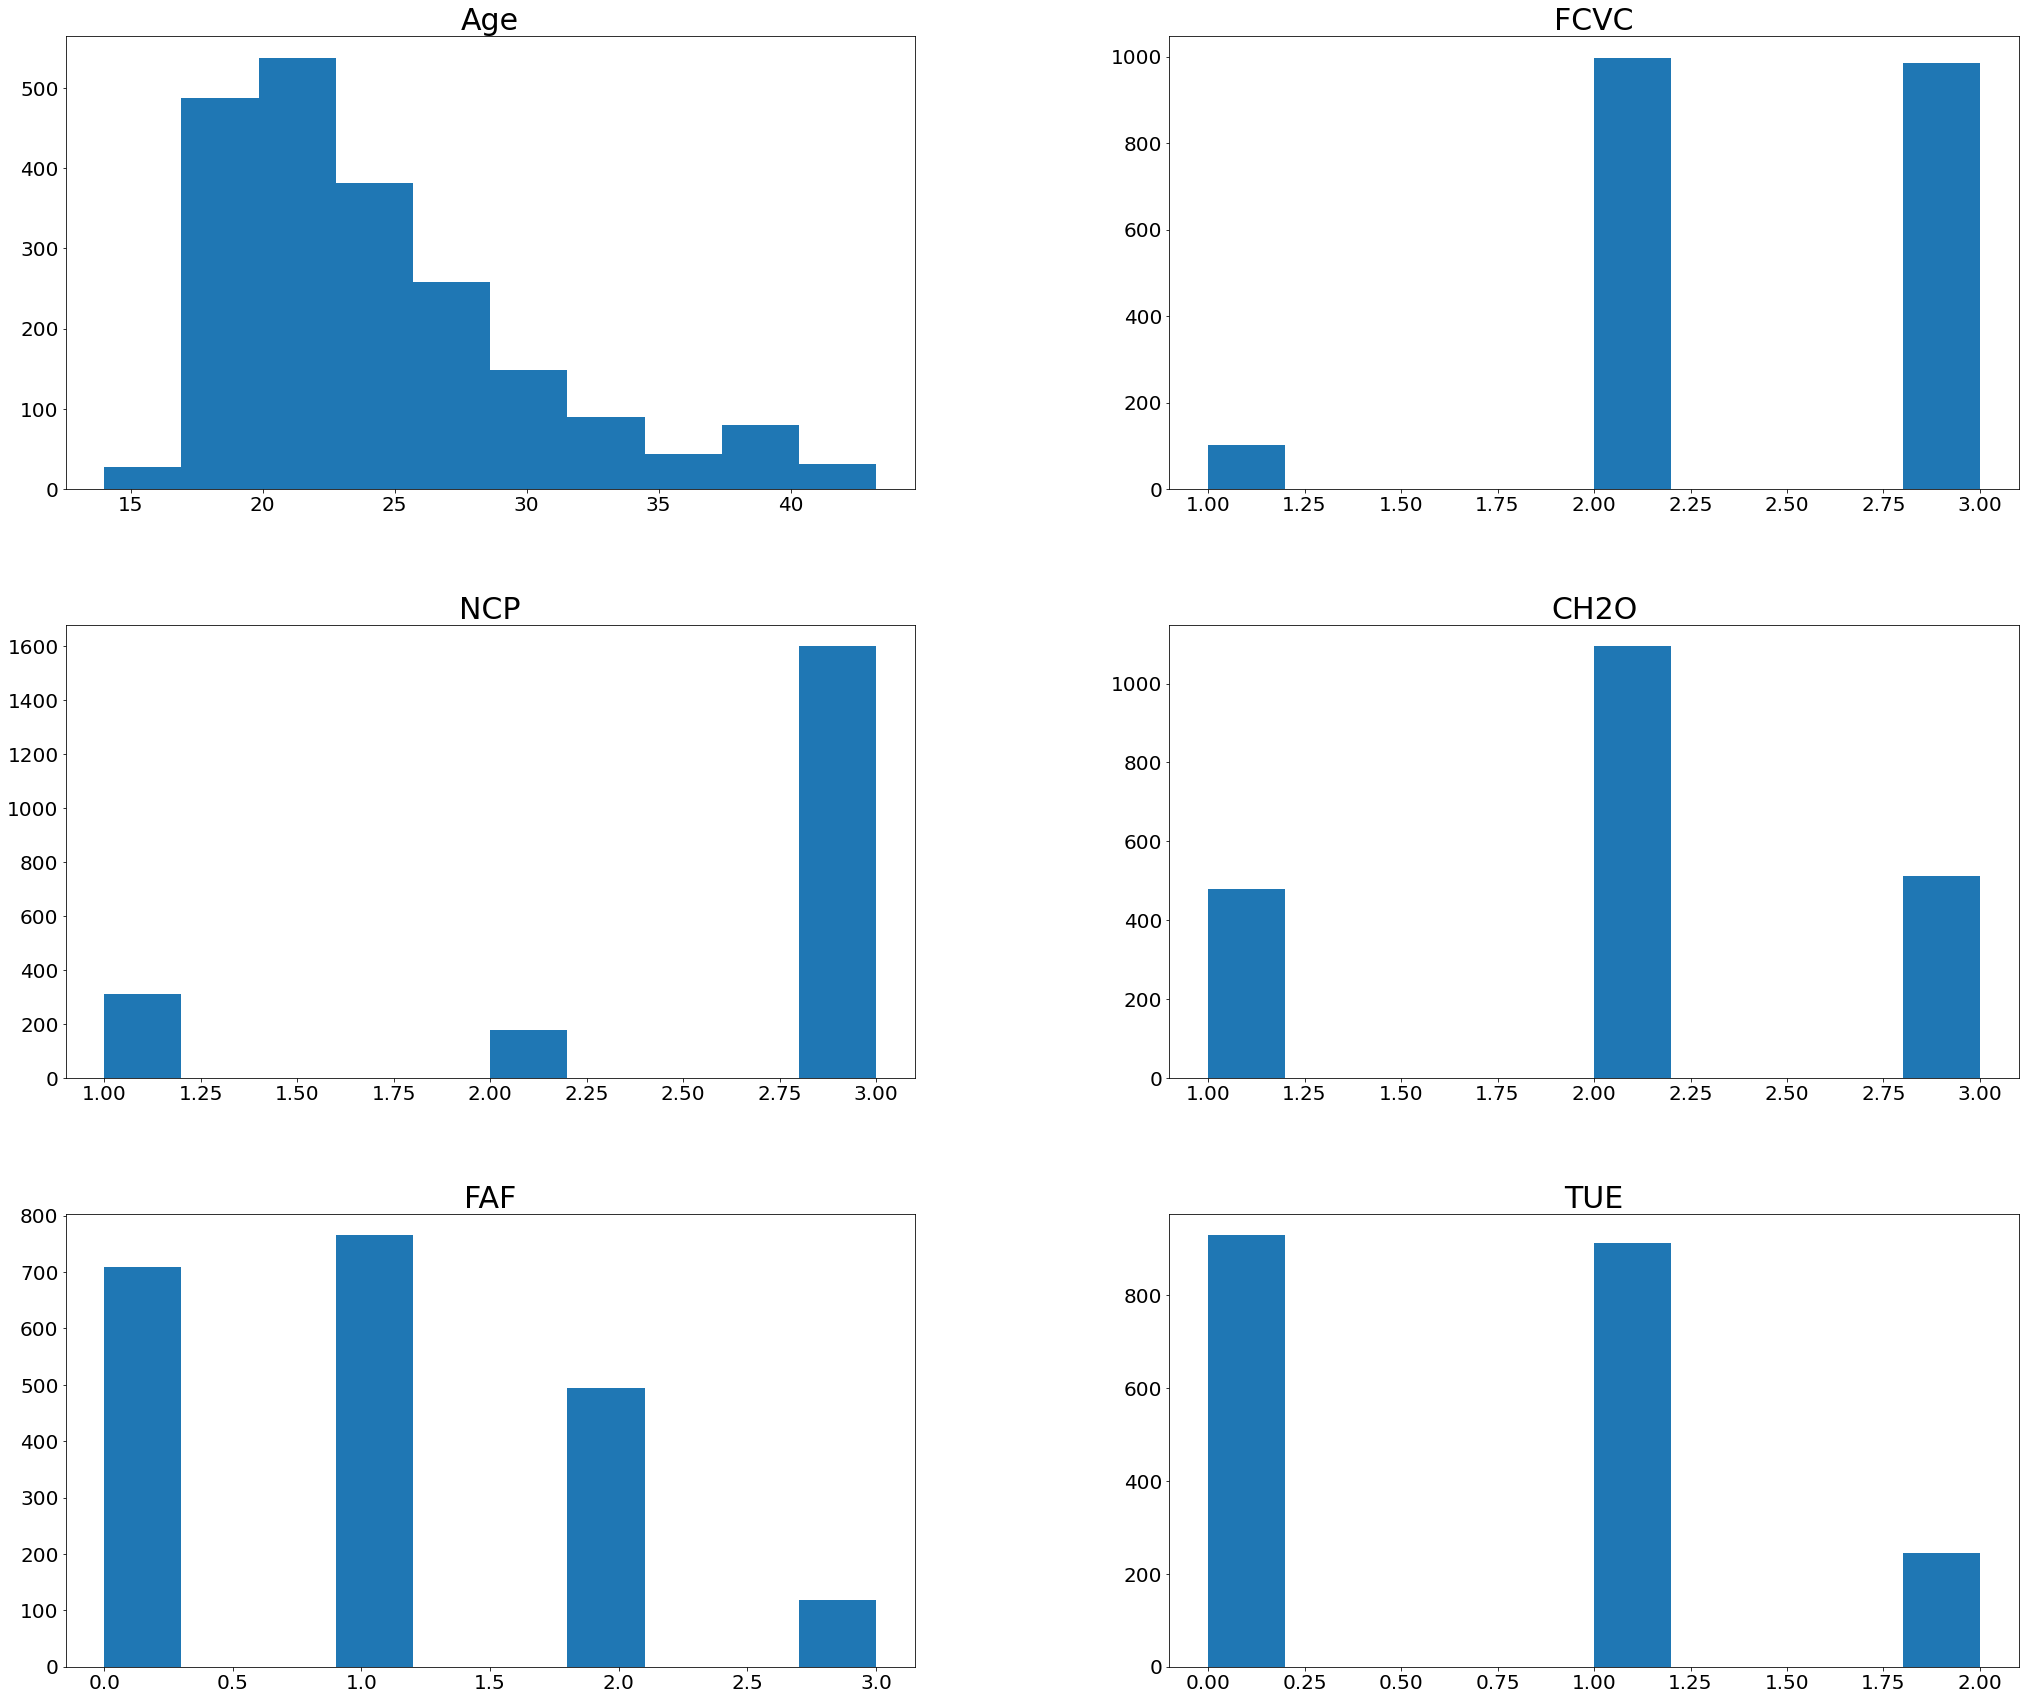

In [14]:
figs = df.hist(figsize=(35, 30), grid = False, xlabelsize=20, ylabelsize=20)
for fig in figs.ravel():
    fig.title.set_size(30)

### Encoding

Encode non-ordinal (nominal) attributes using dummy encoding

In [15]:
columns_encode = ['Gender', 'FHO', 'FAVC', 'SMOKE', 'SCC', 'MTRANS']
df = pd.get_dummies(df, columns=columns_encode, drop_first=True)

columns_display = [c for att in columns_encode for c in df.columns if att in c]
df[columns_display[:6]].head()

,Gender_Male,FHO_yes,FAVC_yes,SMOKE_yes,SCC_yes,MTRANS_Bike
0,0,1,0,0,0,0
1,0,1,0,1,1,0
2,1,1,0,0,0,0
3,1,0,0,0,0,0
4,1,0,0,0,0,0


Encode ordinal attributes (CALC and CAEC).
Both these attributes have possible values of 'Never', 'Sometimes', 'Frequently', 'Always'.

In [16]:
CALC_CAEC_map = {'Never': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3}
df['CALC_scale'] = df['CALC'].replace(CALC_CAEC_map)
df['CAEC_scale'] = df['CALC'].replace(CALC_CAEC_map)
df = df.drop(['CALC', 'CAEC'], axis=1)

Note: MTRANS has more than 2 options and cannot be ordinaly encoded so it will be dropped in the k-nearest neighbors algorithm (because it is based on distances)

### The final preprocessed data

In [17]:
df.sample(10)

,Age,FCVC,NCP,CH2O,FAF,TUE,NObeyesdad,Gender_Male,FHO_yes,FAVC_yes,SMOKE_yes,SCC_yes,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,CALC_scale,CAEC_scale
49,21.000000,2,3,2,0,0,Normal_Weight,0,0,1,0,0,0,0,1,0,1,1
504,26.000000,3,3,2,0,0,Obesity_Type_III,0,1,1,0,0,0,0,1,0,1,1
1160,21.997335,2,3,2,1,2,Overweight_Level_II,1,1,1,0,0,0,0,1,0,0,0
1893,22.980221,3,3,2,1,1,Obesity_Type_III,0,1,1,0,0,0,0,1,0,1,1
1752,27.266287,3,3,3,1,1,Obesity_Type_II,1,1,1,0,0,0,0,1,0,1,1
1518,30.421596,2,3,2,1,0,Obesity_Type_II,1,1,1,0,0,0,0,1,0,1,1
1174,31.965402,2,2,3,1,0,Overweight_Level_II,1,1,1,0,0,0,0,0,0,1,1
1948,20.811580,3,3,2,1,1,Obesity_Type_III,0,1,1,0,0,0,0,1,0,1,1
869,27.000000,2,2,1,1,0,Overweight_Level_I,0,0,1,0,0,0,0,1,0,1,1
1056,24.911994,1,2,2,0,1,Overweight_Level_II,1,1,1,0,0,0,0,1,0,1,1


## Data Mining Methods Used

In this project I implemented the following data mining methods:
- Decision tree
- K-Nearest Neighbors (KNN)
- Association Rules
- Clustering
- Neural Network (Multi-layer percepton)

## Decision Tree

I chose this method because in this dataset there are a lot of categorical attributes, and as mentioned above, this method works well with this type of data. In addition, it is nice to have a visual representation of the results.

### The process of this method

After splitting the data into training and validation data, I will create an instance of the DecisionTreeClassifier from scikit-learn. Then I will tweak the parameters (such as max_leaf_nodes, min_samples_leaf, and min_samples_split) that prevent the tree from being very large and cause overfitting. I will pick the parameter values that yield the best result for the final tree model.

####  Splitting the data to training and testing sets

Splitting the data into X, y - without target column, the target column

In [18]:
 print('shape of df:', df.shape)
columns_lst = [c for c in df.columns if c not in ['NObeyesdad']]
X = df.loc[:, columns_lst]
y = df.loc[:,'NObeyesdad']
print('shapes of X and y', X.shape, y.shape)

shape of df: (2086, 18)
shapes of X and y (2086, 17) (2086,)


Split the data into training and validation data

In [19]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=60)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1460, 17), (626, 17), (1460,), (626,))

#### Creating and tweaking the decision tree model

After a lot of trial and error and tweaking of the parameters I got this tree:

In [20]:
model_tree = tree.DecisionTreeClassifier(max_leaf_nodes=12,
                                         min_samples_leaf=8, 
                                         min_samples_split=8)
model_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_leaf_nodes=12, min_samples_leaf=8,
                       min_samples_split=8)

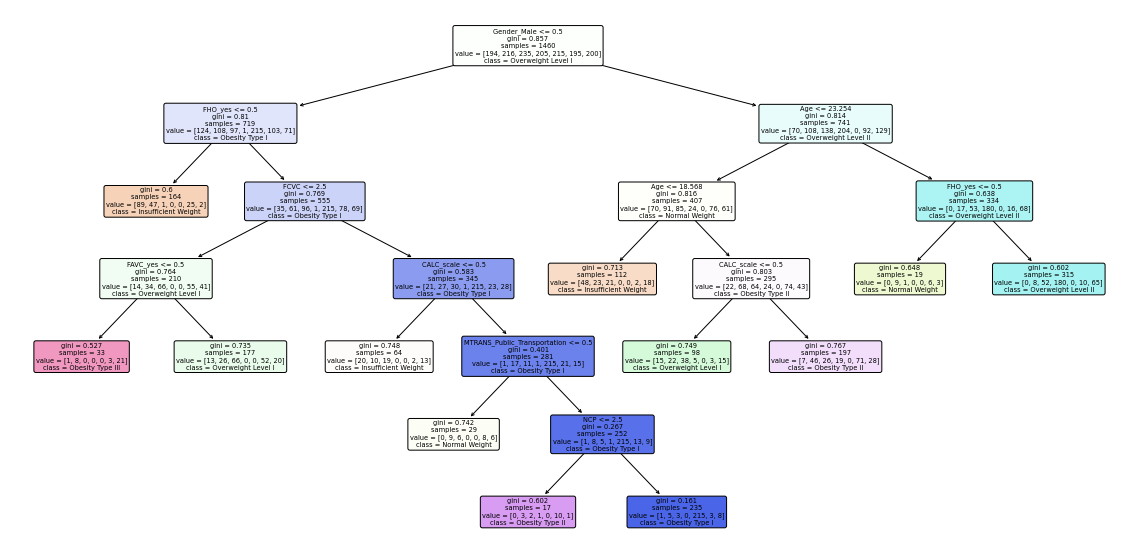

In [21]:
# creates the figure
plt.figure(figsize=(20,10))

# creates the tree plot
plot_tree(model_tree,
           feature_names = columns_lst, #Feature names
           class_names = ['Insufficient Weight', 'Normal Weight', 'Overweight Level I', 'Overweight Level II', 'Obesity Type I', 'Obesity Type II', 'Obesity Type III'], #Class names
           rounded = True,
           filled = True)

plt.show()


### Evaluating the model

In [22]:
y_train_pred = model_tree.predict(X_train)
y_valid_pred = model_tree.predict(X_valid)

print(classification_report(y_valid, y_valid_pred, zero_division=1))

                     precision    recall  f1-score   support

Insufficient_Weight       0.50      0.94      0.65        78
      Normal_Weight       0.18      0.07      0.10        69
     Obesity_Type_I       0.48      0.49      0.48       107
    Obesity_Type_II       0.61      0.87      0.71        92
   Obesity_Type_III       0.93      0.99      0.96       108
 Overweight_Level_I       0.36      0.34      0.35        94
Overweight_Level_II       0.86      0.08      0.14        78

           accuracy                           0.57       626
          macro avg       0.56      0.54      0.49       626
       weighted avg       0.57      0.57      0.52       626



The level of accuracy is 57%.

## K-Nearest-Neighbors (KNN)

I chose this as my second method because all except one of the attibutes are numeric, binary, or ordinal categorical, which allows this algorithm to work well. 

### The process of this method

After splitting the data into training and validation data, I will create an instance of the KNeighborsClassifier from scikit-learn. Then I will tweak the parameter value k (the number of nearest neighbors). I will pick the value of k that yields the best result for the final KNN model.

####  Final data preperations

Splitting the data into X, y - without target column, the target column

In [23]:
# copy X and Y from the decision tree
X_knn = X.copy()
y_knn = y.copy()

remove the columns MTRANS because can't be encoded to work well with KNN

In [24]:
cols = [c for c in df.columns if 'MTRANS' in c]
X_knn = X_knn.drop(cols, axis=1)

####  Scaling - necessary for KNN

In [25]:
min_max_scaler = MinMaxScaler()

X_knn = min_max_scaler.fit_transform(X_knn)

###  Splitting the data to training and testing sets

In [26]:
X_knn_train, X_knn_valid, y_knn_train, y_knn_valid = train_test_split(X_knn, y_knn, test_size=0.3, random_state=42)
X_knn_train.shape, X_knn_valid.shape, y_knn_train.shape, y_knn_valid.shape

((1460, 13), (626, 13), (1460,), (626,))

### Creating the KNN model

In [27]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_knn_train, y_knn_train)

KNeighborsClassifier(n_neighbors=3)

### Evaluating the model

In [28]:
y_knn_train_pred = knn.predict(X_knn_train)
y_knn_valid_pred = knn.predict(X_knn_valid)

print(classification_report(y_knn_valid, y_knn_valid_pred))

                     precision    recall  f1-score   support

Insufficient_Weight       0.57      0.71      0.63        85
      Normal_Weight       0.45      0.41      0.43        93
     Obesity_Type_I       0.64      0.61      0.63       106
    Obesity_Type_II       0.81      0.85      0.83       100
   Obesity_Type_III       0.86      0.98      0.91        87
 Overweight_Level_I       0.70      0.60      0.65        83
Overweight_Level_II       0.59      0.50      0.54        72

           accuracy                           0.67       626
          macro avg       0.66      0.67      0.66       626
       weighted avg       0.66      0.67      0.66       626



The level of accuracy is 67%.

# Conclusion

- The decision tree yielded 57% accuracy and the KNN model yielded 67% accuracy - the KNN model yielded better results.
- The results from the decision tree weren't very high, next time I could choose the parameters in a more systematic way instead of manually (with a function that iterates over possible values and chooses the best ones).
- Initially I didn't think to use k-fold validation because the dataset was quite large, however next time I could try to use k-fold cross validation anyways to improve results.
- Methods using Pandas are often easier than methods in Scikit-learn, but are less efficient (according to several sources online)